# Creation of artificial (synthetic) patient data

Note: This artificial data is intended only for use in exploring the methods, using up to 10 features. The method of synthethis does not maintain any covariance between features (as feature values are created independetly of each other, to eliminate any risk of identifying original data), though average feature values for patients at each hopsital are approximately maintained. These data may be used to train models with minimal loss of accuracy.

The key methodology is:

* Remove thrombolysis label
* Group original data by hopsital
    * For each of 10 features take bootstrap samples of that feature
* Combine data across hospitals
* Remove any duplicate rows, or rows that are identical to original data
* Train an XGBoost model on original data to predict use of thrombolysis
* Use the XGBoost model to leabl the synthetic data

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load data

In [2]:
# Load data
data_loc = '../data/samuel_1/10k_training_test/'
original_data = pd.read_csv(data_loc + 'cohort_10000_train.csv')

# Get stroke teams = 
stroke_teams = list(set(original_data['StrokeTeam']))
stroke_teams.sort()


## Create unlabelled synthetic data by bootstrap sampling from individual feature values

In [3]:
cases = 1000
synthetic_data_list = []

# Sample data for each stroke team
for stroke_team in stroke_teams:
    # Set up data frame for synthetic team data
    synthetic_data = pd.DataFrame()
    
    # Get original team data
    mask = original_data['StrokeTeam'] == stroke_team
    team_data = original_data[mask]
    team_data_length = len(team_data)
    
    # Set team
    synthetic_data['StrokeTeam'] = np.repeat(stroke_team, cases)
    # Sample individual items from orioginal data with replacement

    # Arrival to image time
    synthetic_data['S2BrainImagingTime_min'] = np.random.choice(
        team_data['S2BrainImagingTime_min'], replace=True, size=cases)
    
    # Sample features independently from observed values

    synthetic_data['S2StrokeType_Infarction'] = np.random.choice(
        team_data['S2StrokeType_Infarction'], replace=True, size=cases)

    synthetic_data['S2NihssArrival'] = np.random.choice(
        team_data['S2NihssArrival'], replace=True, size=cases)
    
    synthetic_data['S2RankinBeforeStroke'] = np.random.choice(
        team_data['S2RankinBeforeStroke'], replace=True, size=cases)
    
    synthetic_data['AFAnticoagulent_Yes'] = np.random.choice(
        team_data['AFAnticoagulent_Yes'], replace=True, size=cases)

    synthetic_data['S1OnsetToArrival_min'] = np.random.choice(
        team_data['S1OnsetToArrival_min'], replace=True, size=cases)
    
    synthetic_data['S1AgeOnArrival'] = np.random.choice(
        team_data['S1AgeOnArrival'], replace=True, size=cases)
    
    # Use the same random index for S1OnsetTimeType_Precise and S1OnsetDateType_Stroke
    random_index = np.random.randint(0, team_data_length, size=cases)

    synthetic_data['S1OnsetTimeType_Precise'] = \
            [team_data['S1OnsetTimeType_Precise'].iloc[i] for i in random_index]
    
    synthetic_data['S1OnsetDateType_Stroke during sleep'] = \
            [team_data['S1OnsetDateType_Stroke during sleep'].iloc[i] for i in random_index]    

    # Add team data to full synthetic data
    synthetic_data_list.append(synthetic_data)

# Concatenate lists
synthetic_data_df = pd.concat(synthetic_data_list)

# Shuffle data
synthetic_data_df = synthetic_data_df.sample(frac=1)

In [4]:
image_time = 106
image_time = int((image_time + 5)/ 10) * 10
image_time

110

## Train a model on original data, to use to label synthetic data

In [5]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 10
key_features = pd.read_csv('../data/samuel_1/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append("S2Thrombolysis")

# Select features
train = train[key_features]
test = test[key_features]

# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs_original = model.predict_proba(X_test)[:,1]
y_pred_original = y_probs_original > 0.5

# Show accuracy
accuracy = np.mean(y_pred_original == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.848


## Predict label for synthetic data set

In [6]:
# One hot encode hopsitals
X_features = key_features.copy(); X_features.remove('S2Thrombolysis')
X_synthetic = synthetic_data_df[X_features]
X_synthetic_hosp = pd.get_dummies(X_synthetic['StrokeTeam'], prefix = 'team')
X_synthetic = pd.concat([X_synthetic, X_synthetic_hosp], axis=1)
X_synthetic.drop('StrokeTeam', axis=1, inplace=True)

In [7]:
# Get predicted probabilities and class
y_probs = model.predict_proba(X_synthetic)[:,1]
y_pred = np.array([np.random.binomial(1, p) for p in y_probs])

# Ensure non-iscaemica stroke have no thrombolysis
mask = synthetic_data_df['S2StrokeType_Infarction'] == 0
y_pred[mask] = 0

synthetic_data_df['S2Thrombolysis'] = y_pred
# Save
synthetic_data_df.to_csv('./output/synthetic_10K_train.csv', index=False)

In [8]:
synthetic_data_df

,StrokeTeam,S2BrainImagingTime_min,S2StrokeType_Infarction,S2NihssArrival,S2RankinBeforeStroke,AFAnticoagulent_Yes,S1OnsetToArrival_min,S1AgeOnArrival,S1OnsetTimeType_Precise,S1OnsetDateType_Stroke during sleep,S2Thrombolysis
479,TKRKH4920C,30.0,1,7.0,1,0,101.0,77.5,0,0,0
777,JHDQL1362V,33.0,1,3.0,0,0,102.0,17.5,0,1,0
340,XIGJJ1201J,290.0,1,3.0,1,0,234.0,82.5,1,0,0
500,OYASQ1316D,56.0,0,17.0,0,0,114.0,67.5,1,0,0
387,TPFFP4410O,38.0,1,7.0,0,0,70.0,77.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
779,BQZGT7491V,18.0,1,1.0,3,0,151.0,62.5,1,0,0
337,VZOCK3505U,28.0,1,10.0,3,0,125.0,97.5,1,0,1
906,YQMZV4284N,131.0,1,2.0,4,0,221.0,42.5,1,0,0
30,DZJVD1372Z,430.0,1,20.0,0,0,150.0,97.5,1,0,0


## Test synthetic data to train model

In [9]:
# Load data
train = synthetic_data_df
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Select features
train = train[key_features]
test = test[key_features]

# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)    

# Define model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

# Fit model
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs_synthetic = model.predict_proba(X_test)[:,1]
y_pred_synthetic = y_probs_synthetic > 0.5

# Show accuracy
accuracy = np.mean(y_pred_synthetic == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.845


In [10]:
# Get ROC curves
fpr_o, tpr_o, thresholds_o = roc_curve(y_test, y_probs_original)
roc_auc_o = auc(fpr_o, tpr_o)
fpr_s, tpr_s, thresholds_s = roc_curve(y_test, y_probs_synthetic)
roc_auc_s = auc(fpr_s, tpr_s)

# Print results
print(f'Original AUC: {roc_auc_o:.3f}')
print(f'Synthetic AUC: {roc_auc_s:.3f}')

Original AUC: 0.915
Synthetic AUC: 0.915


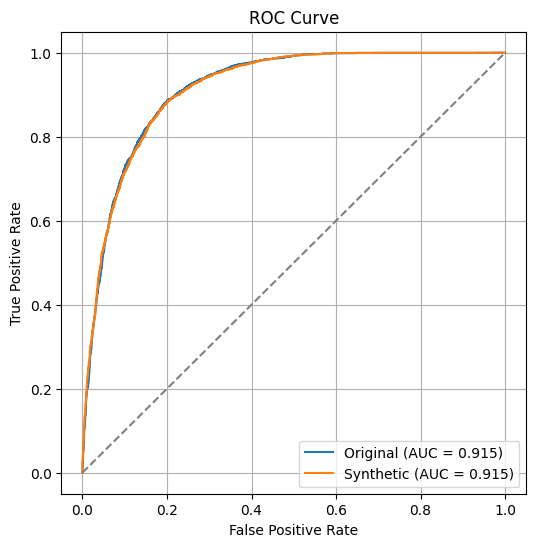

In [11]:
# Plot ROC curves
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.plot(fpr_o, tpr_o, label=f'Original (AUC = {roc_auc_o:.3f})')
ax.plot(fpr_s, tpr_s, label=f'Synthetic (AUC = {roc_auc_s:.3f})')
ax.plot([0,1], [0,1], linestyle='--', color='grey')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend()
ax.grid()
plt.show()


## Examine distances between synthetic-real and real-real near neighbours

Distance are Cartesian distance between standardised data points.

### Function to standardise data

In [12]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [13]:
# Set up lists to store results
all_dist_real_real = []
all_dist_real_synthetic = []

for stroke_team in stroke_teams:

    # Get original team data
    mask = original_data['StrokeTeam'] == stroke_team
    team_original = original_data[mask][key_features]
    team_original.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1, inplace=True)
    original_size = len(team_original)

    # Get synthetic data (match sample size to orginal data)
    mask = synthetic_data_df['StrokeTeam'] == stroke_team
    team_synthetic = synthetic_data_df[mask][key_features]
    team_synthetic.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1, inplace=True)
    synthetic_size = len(team_synthetic)

    # Reduce larger set to size of small set
    if synthetic_size > original_size:
        team_synthetic = team_synthetic.sample(original_size)
    else:
        team_original = team_original.sample(synthetic_size)

    # Standardise
    team_original_std, team_synthetic_std = standardise_data(
        team_original, team_synthetic)

    # Get nearest neighbour distances in real data
    nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(team_original_std)
    dists, idxs = nn.kneighbors()
    dist_real_real = dists.flatten()
    all_dist_real_real.append(dist_real_real)

    # Get closest real data point to synthetic data points
    dists, idxs = nn.kneighbors(team_synthetic_std)
    dist_real_synthetic = dists.flatten()
    all_dist_real_synthetic.append(dist_real_synthetic)

# Concatenate all distances
all_dist_real_real = np.concatenate(np.array(all_dist_real_real))
all_dist_real_synthetic = np.concatenate(np.array(all_dist_real_synthetic))

Show mean distances to closest real data point.

In [14]:
print (f'Mean real-real distance: {np.mean(all_dist_real_real):.3f}')
print (f'Mean real-synthetic distance: {np.mean(all_dist_real_synthetic):.3f}')

Mean real-real distance: 0.697
Mean real-synthetic distance: 0.766


Plot distribution of distances to closest real data point.

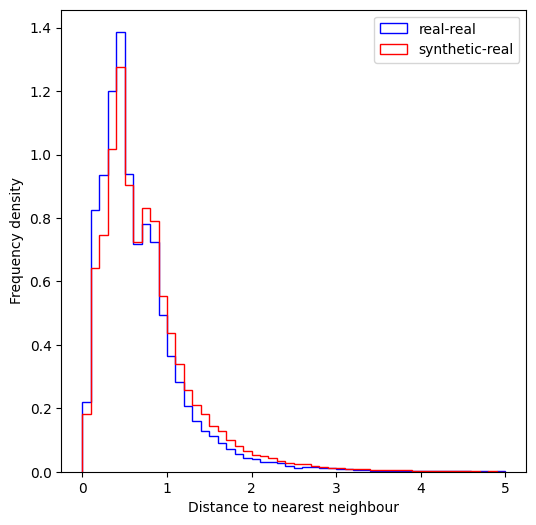

In [15]:
# Plot histogram of distances to nearest real data point
bins = np.arange(0, 5.1, 0.1)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(all_dist_real_real, bins=bins, histtype='step', color='b', 
        density=True, label='real-real')
ax.hist(all_dist_real_synthetic, bins=bins, histtype='step', color='r', 
        density=True, label='synthetic-real')

ax.set_xlabel('Distance to nearest neighbour')
ax.set_ylabel('Frequency density')
ax.legend()
plt.show()

### Kolmogorov-Smirnov test for goodness of fit

The Kolmogorov-Smirnov (KS) test for goodness of fit is a statistical test that compares the distribution of a sample to a theoretical distribution or a reference distribution. The test is used to determine whether the sample is drawn from the reference distribution or a different distribution.

The KS test works by calculating the maximum distance between the cumulative distribution function (CDF) of the sample and the CDF of the reference distribution. The test statistic, called the D statistic, is the maximum absolute difference between the two CDFs. The null hypothesis of the KS test is that the sample is drawn from the reference distribution, and the alternative hypothesis is that the sample is drawn from a different distribution.

The KS test can be used to test the goodness of fit of a wide range of distributions, including normal, exponential, and uniform distributions. It is a non-parametric test, which means that it does not make any assumptions about the underlying distribution of the data.

In scipy `ks_2samp` tests the goddness between two sampled distributions (whereas `kstest` would test the difference between a samplesd and a theoretical distribution).

In [16]:
# Kolmogorov-Smirnov test for goodness of fit.
ks_stat, p_value = stats.ks_2samp(all_dist_real_real, all_dist_real_synthetic)
print (f'KS statistic: {ks_stat:.3f}')
print (f'p-value: {p_value:.3f}')

KS statistic: 0.074
p-value: 0.000


### Kullback-Leibler (KL) Divergence

KL divergence is a measure of the difference between two probability distributions. It measures how much information is lost when approximating one distribution with the other. It is a non-symmetric measure, meaning that the distance from distribution A to distribution B may be different from the distance from B to A.

Calculation:

* Let P and Q be the two probability distributions that you want to compare.
* Compute the pointwise ratio of the two distributions: R(x) = P(x) / Q(x).
* Calculate the integral or sum of P(x) times the logarithm of R(x) over the entire support of P(x): KL(P||Q) = ∫ P(x) log (P(x) / Q(x)) dx.

Note that KL divergence is not symmetric, meaning that KL(P||Q) may be different from KL(Q||P).

Kullback-Leibler (KL) Divergence can sometimes result in an infinite value when one distribution has zero probability mass at a point where the other distribution has a non-zero probability mass. To avoid this issue, you can either smooth the distributions or add a small constant value to the probability mass to ensure that there are no zero probabilities.

In [17]:
## Measure Kullback-Leibler divergence from synthetic to real data

# Bin original and synthetic data
bins = np.arange(0, 5.1, 0.1)
p, _ = np.histogram(all_dist_real_real, bins=bins, density=True)
q, _ = np.histogram(all_dist_real_synthetic, bins=bins, density=True)

# Normalize the distributions to make sure they sum to 1
p = p / np.sum(p)
q = q / np.sum(q)


# Calculate and print the KL divergence
kl_div = stats.entropy(p, q)
print (f'KL divergence: real || synthetic {kl_div:.3f}')

## Measure Kullback-Leibler divergence from real to synthetic data

# Calculate and print the KL divergence
kl_div = stats.entropy(q, p)
print (f'KL divergence: synthetic || real {kl_div:.3f}')

KL divergence: real || synthetic 0.016
KL divergence: synthetic || real 0.017


### Jensen-Shannon (JS) Divergence

JS divergence is a symmetrized and smoothed version of KL divergence. It measures the similarity between two probability distributions by computing the average KL divergence between them and their midpoint.

Calculation:

* Let P and Q be the two probability distributions that you want to compare.
* Compute the midpoint distribution M = (P + Q) / 2.
* Calculate the KL divergence between each distribution and the midpoint distribution: KL(P||M) and KL(Q||M).
* Calculate the JS divergence as the average of the two KL divergences: JS(P,Q) = (KL(P||M) + KL(Q||M)) / 2.

Note that JS divergence is a symmetrized and smoothed version of KL divergence.

In [18]:
## Measure Jensen-Shannon (JS) Divergence

# Bin original and synthetic data
bins = np.arange(0, 5.1, 0.1)
p, _ = np.histogram(all_dist_real_real, bins=bins, density=True)
q, _ = np.histogram(all_dist_real_synthetic, bins=bins, density=True)

# Normalize the distributions to make sure they sum to 1
p = p / np.sum(p)
q = q / np.sum(q)

js_div = jensenshannon(p, q)
print (f'JS Divergence: {js_div:.3f}')

JS Divergence: 0.064
